In [1]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import re
from niceboxplot import *
from warnings import filterwarnings
import matplotlib.patches as mpatches
import matplotlib.colors as mpcol
import scipy.stats
linregress = scipy.stats.linregress
import scipy as sp
filterwarnings("ignore")
import pickle

In [2]:

############################################
# Helferfunktionen zum Zählen und Ersetzen #
############################################

def countElWithNum(col):
    out = [0,0,0,0,0]
    for el in col:
        if type(el)==float: continue
        elif type(el)==int: out[el-1] += 1
        elif not re.search("\d",el): continue
        else: out[int(re.sub(r"\D","",el))-1] += 1
    return out

def countAnswers(data):
    for (colname,col) in data.items():
        if colname=="Gender":
            m = 0; f = 0; d = 0
            for el in col:
                if el=="Männlich": m+=1
                elif el=="Weiblich": f+=1
                else: d+=1
            gender = [m,f,d]
        elif colname=="Wie lange betreiben Sie ihre Kampfkunst?":
            k = 0; a = 0; b = 0; c = 0; d = 0
            for el in col:
                if type(el)== float: continue
                elif re.search("Keine", el): k+=1
                elif re.search("< 1", el): a+=1
                elif re.search("1-2", el): b+=1
                elif re.search("2-5", el): c+=1
                elif re.search("> 5", el): d+=1
            dauer = [k,a,b,c,d]
        elif colname=="Wie schätzen sie Ihre Fähigkeiten ein?":
            fähigkeit = countElWithNum(col)
        elif colname=="Haben sie Wettkampferfahrung?":
            wettkampf = countElWithNum(col)
        elif colname=="Haben Sie Auswirkungen auf ihr Sozialverhalten bemerkt, nachdem sie begonnen haben eine Kampfkunst zu praktizieren? ":
            j = 0; n = 0; v = 0
            for el in col:
                if el=="Ja": j+=1
                elif el=="Nein": n+=1
                elif el=="Vielleicht": v+=1
            veränderung = [j,n,v]
            

    return {
        "Gender":gender,
        "Dauer":dauer,
        "Fähigkeit":fähigkeit,
        "Wettkampf":wettkampf,
        "Veränderung":veränderung
    }

def getKampfsportler(selfData):
    return selfData[
        (selfData["Haben sie in der Vergangenheit eine Kampfkunst / Kampfsport ausgeübt? (Trifft nicht zu auswählen, wenn sie aktuell Kampfsport betreiben)"]=="Trifft nicht zu") |
        (selfData["Haben sie in der Vergangenheit eine Kampfkunst / Kampfsport ausgeübt? (Trifft nicht zu auswählen, wenn sie aktuell Kampfsport betreiben)"]=="Ja")
    ].index

################################
# Regression Helper Funktionen #
################################

def plot_ci_bootstrap(xs, ys, resid, color="b-", nboot=500, ax=None):
    if len(xs) != len(ys): print(xs)
    for _ in range(nboot):
        try:
            resamp_resid = resid[np.random.randint(1, len(resid) - 1, len(resid))]
            pc = sp.polyfit(xs, pd.Series([a+b for a,b in zip(list(ys), list(resamp_resid))]), 1)                   
            ax.plot(xs, sp.polyval(pc, xs), color, linewidth=2, alpha=1.5 / float(nboot))
        except KeyError: pass
    return ax

def calcFitParams(fitRes,data):
    x = data[0]; y = data[1]; dof = len(data[0]) - 2
    x_model = data[0]; y_model = [fitRes.slope*i + fitRes.intercept for i in x]
    resid = y - y_model
    chi2 = np.sum((resid / y_model)**2)                        
    s_err = np.sqrt(np.sum(resid**2) / dof)
    return {
        "resid":resid,
        "chi2":chi2,
        "s_err": s_err
    } 

##############################################
#                            #
#   Grooooooße Funktionen    ###
#                            #
########################################



def cleanSheetData(RawSheets):

    # Läd Daten, eretzt Antwortmöglichkeiten mit zugehöriger Zahl.
    # Returns Liste der ausgefüllten Tests

    #
    # 1: Helferfunktionen
    #

    def replacer(item,dic):
        # HelferFunktion die str mit Zahl ersetzt
        if "," in item and item != "Weder Charakteristisch , noch Uncharakteristisch":
            items = item.split(",")
            for i,item in enumerate(items):
                if item.startswith(" "): items[i] = item[1:]
                if item.endswith(" "): items[i] = item[:-1]
            if len(items)==3:
                if items[0]=="Klingt etwas nach mir": return 3.5
                if items[0]=="Klingt nicht ganz nach mir": return 2.5
            else:
                scores = [dic[i] for i in items]
                return np.mean(scores)
        else:
            return dic[item]

    def replaceRatingWithNumber(questionair,dic):
        # HelferFunktion die über Fragebögen iteriert und mit replacer() str zu int ersetzt 
        # params: questionair -> Datensatz den Fragebogens, dic -> Wörterbuch das Antwortstr eine Zahl zuordnet
        for column in questionair.items():
            for i,item in enumerate(column[1]):
                if type(item)!=int:
                    if item in list(dic.keys()):
                        questionair[column[0]][i] = replacer(item,dic)
                    elif type(item)==float:
                        questionair[column[0]][i] = item
                    elif "," in item and item != "Weder Charakteristisch , noch Uncharakteristisch":
                        questionair[column[0]][i] = replacer(item,dic)
                    else:
                        questionair[column[0]][i] = np.nan
        return questionair

    def cleanSQ(datapoint):
        # 
        if type(datapoint)==str:
            match re.sub(r"\D","",datapoint):
                case "": return np.nan
                case "1"|"2"|"3"|"4"|"5": return int(re.sub(r"\D","",datapoint))
                case "12": return 1.5
                case "25": return 3.5 
                case _: return np.nan
        else: return datapoint

    def compileSheet(sheet):
        # Teilt die Daten in die jeweiligen Fragebögen auf
        out = [pd.DataFrame(range(len(list(sheet["Gender"].dropna()))),columns=["Proband"]) for _ in range(5)]
        lastQuestionIndex = 0
        currentQuestionaireIndex = 0
        strQuestions = False
        for question in sheet.columns:
            if not str(question)[0].isdigit():
                out[currentQuestionaireIndex] = pd.concat([out[currentQuestionaireIndex], pd.DataFrame(sheet[question])],axis=1)
            else:
                if strQuestions==False: 
                    currentQuestionaireIndex += 1
                    strQuestions = True
                if int(str(question).split(".")[0]) > lastQuestionIndex:
                    out[currentQuestionaireIndex] = pd.concat([out[currentQuestionaireIndex], pd.DataFrame(sheet[question])],axis=1)
                    lastQuestionIndex += 1
                else:
                    if currentQuestionaireIndex < 4: currentQuestionaireIndex += 1
                    lastQuestionIndex = 0
                    out[currentQuestionaireIndex] = pd.concat([out[currentQuestionaireIndex], pd.DataFrame(sheet[question])],axis=1)
        return out
    
    #
    # 2: Compilen der Sheets
    #
    
    # Dic um Antworten in Zahlen zu übersetzen
    with open("ratingDic.json", "r", encoding="utf-8") as file:
        ratingDic = json.load(file)
    with open("fragebogenDic.json", "r", encoding="utf-8") as file:
        fragebogenDic = json.load(file)

    sheets = [ sheet.drop(columns="Zeitstempel").iloc[:len(list(sheet["Gender"].dropna())),:] for sheet in RawSheets]
    
    compiledSheets = []
    for sheet in sheets:
        compiledSheets.append(compileSheet(sheet))
    
    # Ersetzt Antwort str mit zugehörigem int
    for j,compiledSheet in enumerate(compiledSheets):
        for i,questionair in enumerate(compiledSheet[1:]):
            compiledSheet[i+1] = replaceRatingWithNumber(questionair,ratingDic)
        compiledSheets[j] = compiledSheet
        compiledSheet.append(compiledSheet[0].applymap(cleanSQ))

    return compiledSheets


def prepSheetDataforVis(cleanSheets):

    def CalcOneDimRes(data):
        resDF = data.iloc[:,1:]
        results = resDF.fillna(0).sum(axis=1)
        results.index = list(range(results.shape[0]))
        out = data["Proband"]
        out = pd.concat([out,results],axis=1)
        return out

    def CalcBPAQResults(data):
        return CalcOneDimRes(data).iloc[1:,:].set_axis(["Proband","BPAQ"],axis=1)

    def CalcSCSResults(data):
        return CalcOneDimRes(data).iloc[1:,:].set_axis(["Proband","SCS"],axis=1)

    def CalcPSCSResults(data):
        return CalcOneDimRes(data).iloc[1:,:].set_axis(["Proband","PSCS"],axis=1)

    def CalcPANASResults(data):
        PANASpositive = data[["1. Interessiert","3. Aufgeregt","5. Stark","9. Enthusiastisch","10. Stolz","12. Achtsam","14. Inspiriert ","16. Bestimmt","17. Achtsam"]]
        PANASpositiveResults = PANASpositive.sum(axis=1)
        PANASnegative = data[['2. Betrübt','4. Verärgert','6. Schuldig','7. Verärgert','8. Feindlich','11. Reizbar','13. Beschämt','15. Nervös','18. Zitterig, Nervös, Überspannt']]
        PANASnegativeResults = PANASnegative.sum(axis=1)
        return pd.concat([data["Proband"],PANASpositiveResults,PANASnegativeResults],axis=1).set_axis(["Proband","PANAS Positive","PANAS Negative"],axis=1) 

    def NormResults(res):
        out = pd.DataFrame([])
        for colname, col in res.items():
            if colname!="Proband":
                with open("fragebogenDic.json", "r", encoding="utf-8") as file:
                    fragebogenDic = json.load(file)
                max = fragebogenDic[colname]*5
                min = fragebogenDic[colname]
                out[colname] = col.apply(lambda x: (x / max) * (x-min)/(max-min))
        return out

    def sortForKS(results,selfData):
        kampfsportler = getKampfsportler(selfData)
        KSresults = results[results["Proband"].isin(kampfsportler)].iloc[:,1:].dropna()
        KSresults.columns = [col+" KS" for col in KSresults.columns]
        NKSresults = results[results["Proband"].isin(kampfsportler).apply(lambda x: False if x else True)].iloc[:,1:].dropna()
        NKSresults.columns = [col+" NKS" for col in NKSresults.columns]
        return pd.concat([NKSresults,KSresults]).sort_index()
    
    def sortOneSheet(cleanSheet):
        SQ,BPAQ,SCS,PANAS,PSCS,cleanSQ = cleanSheet
        Results = pd.DataFrame([])
        BPAQResults = CalcBPAQResults(BPAQ)
        SCSResults = CalcSCSResults(SCS)
        PSCSResults = CalcPSCSResults(PSCS)
        PANASResults = CalcPANASResults(PANAS)
        Results = pd.concat([Results,BPAQResults])
        Results = pd.concat([Results,SCSResults["SCS"],PSCSResults["PSCS"],PANASResults[["PANAS Positive","PANAS Negative"]]],axis=1)
        Results = Results.applymap(lambda x: x if x!=0 else np.nan).dropna()
        ResultsNorm = pd.concat([Results["Proband"],NormResults(Results)],axis=1).dropna()
        sortedResults = sortForKS(Results,SQ)
        sortedResultsNorm = sortForKS(ResultsNorm,SQ)
        return {
            "Results": Results.set_index("Proband"),
            "ResultsNorm": ResultsNorm.set_index("Proband"),
            "sortedResults": sortedResults,
            "sortedResultsNorm": sortedResultsNorm,
            "SQ": SQ,
            "cleanSQ": cleanSQ.set_index("Proband")
        }
    
    def CombineResults(ResultsList):
        DataFromSheet1, DataFromSheet2 = ResultsList
        for key in DataFromSheet2:
            DataFromSheet2[key] = DataFromSheet2[key].rename(index={i:i+DataFromSheet1[key].shape[0] for i in DataFromSheet2[key].index})
            if key=="sortedResults" or key=="sortedResultsNorm": 
                DataFromSheet2[key] = DataFromSheet2[key].rename(columns={col:" ".join(col.split(" ")[:-1])+" trad" for col in DataFromSheet2[key].columns}).dropna(axis="columns")
        return [
            pd.concat([
                pd.concat([DataFromSheet1["SQ"],pd.DataFrame({"sheet":["Data1" for _ in range(DataFromSheet1["SQ"].shape[0])]},index=[i for i in range(DataFromSheet1["SQ"].shape[0])])],axis=1),
                pd.concat([DataFromSheet2["SQ"],pd.DataFrame({"sheet":["Data2" for _ in range(DataFromSheet2["SQ"].shape[0])]},index=[i for i in range(DataFromSheet2["SQ"].index[0],DataFromSheet2["SQ"].index[-1]+1)])],axis=1)
            ],axis=0),
            pd.concat([DataFromSheet1["cleanSQ"],DataFromSheet2["cleanSQ"]],axis=0),
            pd.concat([DataFromSheet1["sortedResults"],DataFromSheet2["sortedResults"]],axis=0),
            pd.concat([DataFromSheet1["sortedResultsNorm"],DataFromSheet2["sortedResultsNorm"]],axis=0),
            pd.concat([DataFromSheet1["Results"],DataFromSheet2["Results"]],axis=0),
            pd.concat([DataFromSheet1["ResultsNorm"],DataFromSheet2["ResultsNorm"]],axis=0)
        ]
    
    BothResults = []
    for sheet in cleanSheets:
        BothResults.append(sortOneSheet(sheet))

    return CombineResults(BothResults)

In [5]:
CSD = cleanSheetData([pd.read_excel("./social competence (Antworten).xlsx"),pd.read_excel("./social competence taichi (Antworten).xlsx")])
SQ, cleanSQ, Results, ResultsNorm, ResultsAll, ResultsAllNorm = prepSheetDataforVis(CSD)


In [11]:
Results["BPAQ NKS"].dropna().shape

(23,)

In [12]:
SQ['Beschreiben Sie kurz ihr Verhätnis zur Kampfkunst. (z.B Motivation für die Ausübung, Warum Sie die Kampfkunst begonnen haben) \nDiese Frage kann auch unbeantwortet bleiben.'].dropna().shape

(56,)

In [ ]:
with open("SQ.p","wb") as file: pickle.dump(SQ,file)

In [38]:
len([a for a in SQ["Alter"] if a<18])

28

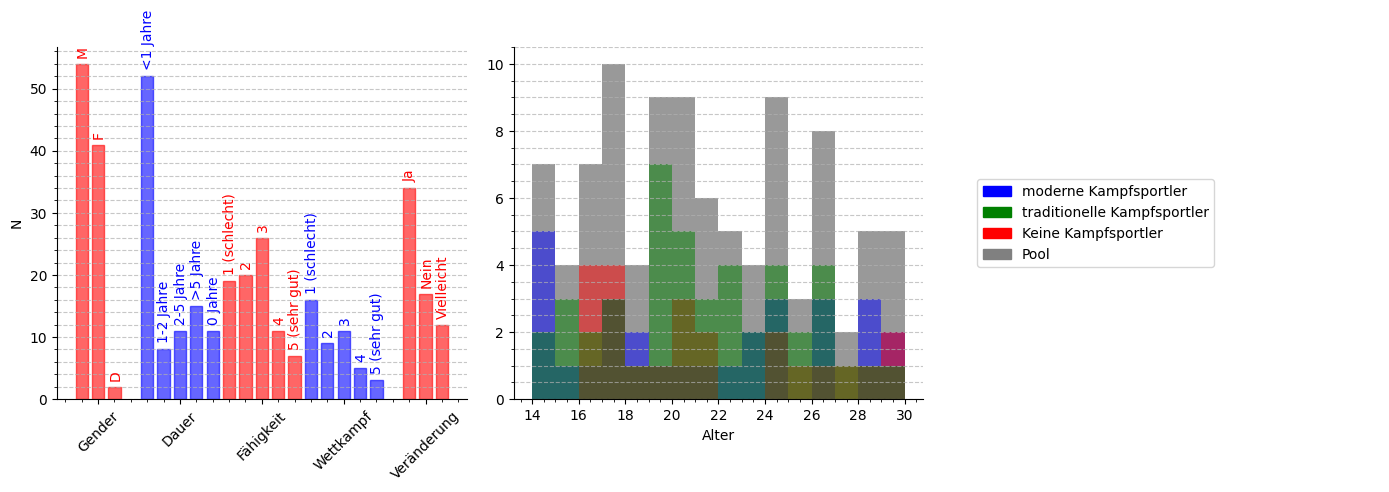

In [13]:
fig = plt.figure(figsize=(14,5),dpi=100)
axBar, axAge, axLegend = [fig.add_subplot(1,3,i) for i in range(1,4)]

Ns = countAnswers(SQ)
# print(Ns)

bars = axBar.bar(
    x=[
        0.8,1,1.2,
        1.6,1.8,2,2.2,2.4,
        2.6,2.8,3,3.2,3.4,
        3.6,3.8,4,4.2,4.4,
        4.8,5,5.2
    ],
    height=[
        *Ns["Gender"],
        *Ns["Dauer"],
        *Ns["Fähigkeit"],
        *Ns["Wettkampf"],
        *Ns["Veränderung"]
    ],
    width=0.15,alpha=0.6
)

for bar in bars:
    col = ["red","blue"]
    bar.set_color(col[round(bar.get_x()%2)-1])
    x = bar.get_x()
    textSetter = lambda text: axBar.text(bar.get_x(),bar.get_height()+1,text,verticalalignment="bottom",rotation=90,color=col[round(bar.get_x()%2)-1])
    match round(x):
        case 1:
            match round(x,1):
                case 0.7: textSetter("M")
                case 0.9: textSetter("F")
                case 1.1: textSetter("D")
        case 2:
            match round(x,1):
                case 1.5: textSetter("<1 Jahre")
                case 1.7: textSetter("1-2 Jahre")   
                case 1.9: textSetter("2-5 Jahre")
                case 2.1: textSetter(">5 Jahre")
                case 2.3: textSetter("0 Jahre")
        case 3:
            match round(x,1):
                case 2.5: textSetter("1 (schlecht)")
                case 2.7: textSetter("2")   
                case 2.9: textSetter("3")
                case 3.1: textSetter("4")
                case 3.3: textSetter("5 (sehr gut)")
        case 4:
            match round(x,1):
                case 3.5: textSetter("1 (schlecht)")
                case 3.7: textSetter("2")   
                case 3.9: textSetter("3")
                case 4.1: textSetter("4")
                case 4.3: textSetter("5 (sehr gut)")
        case 5:
            match round(x,1):
                case 4.7: textSetter("Ja")
                case 4.9: textSetter("Nein")
                case 5.1: textSetter("Vielleicht")
            
            
axBar.spines.top.set_visible(False); axBar.spines.right.set_visible(False)
axBar.set_xticklabels(["","Gender","Dauer","Fähigkeit","Wettkampf","Veränderung"],rotation=45)
axBar.minorticks_on()
axBar.grid(which="both",axis="y",ls="--",alpha=0.7)
axBar.set_ylabel("N")

kampfsportler = getKampfsportler(SQ)
KSAge = SQ[SQ.index.isin(kampfsportler)]["Alter"]
NKSAge = SQ[~SQ.index.isin(kampfsportler)]["Alter"]

axAge.hist(SQ["Alter"],bins=int(SQ["Alter"].max()-SQ["Alter"].min()),alpha=0.8,color="grey",range=[SQ["Alter"].min(),SQ["Alter"].max()])
axAge.hist(KSAge.iloc[:29],bins=int(SQ["Alter"].max()-SQ["Alter"].min()),alpha=0.5,color="blue",range=[SQ["Alter"].min(),SQ["Alter"].max()])
axAge.hist(NKSAge,bins=int(SQ["Alter"].max()-SQ["Alter"].min()),alpha=0.5,color="red",range=[SQ["Alter"].min(),SQ["Alter"].max()])
axAge.hist(KSAge.iloc[29:],bins=int(SQ["Alter"].max()-SQ["Alter"].min()),alpha=0.5,color="green",range=[SQ["Alter"].min(),SQ["Alter"].max()])
axAge.spines.top.set_visible(False); axAge.spines.right.set_visible(False)
axAge.set_xlabel("Alter")
axAge.minorticks_on()
axAge.grid(which="both",axis="y",ls="--",alpha=0.7)
axLegend.legend(handles=[mpatches.Patch(color=col, label=la) for col, la in zip(["blue","green","red","grey"],["moderne Kampfsportler","traditionelle Kampfsportler","Keine Kampfsportler","Pool"])],loc="center left")
axLegend.spines.top.set_visible(False); axLegend.spines.right.set_visible(False); axLegend.spines.left.set_visible(False); axLegend.spines.bottom.set_visible(False)
axLegend.set_xticks([]); axLegend.set_yticks([])

plt.tight_layout()
plt.savefig("./ResultsImg/SQData.svg")

plt.show()

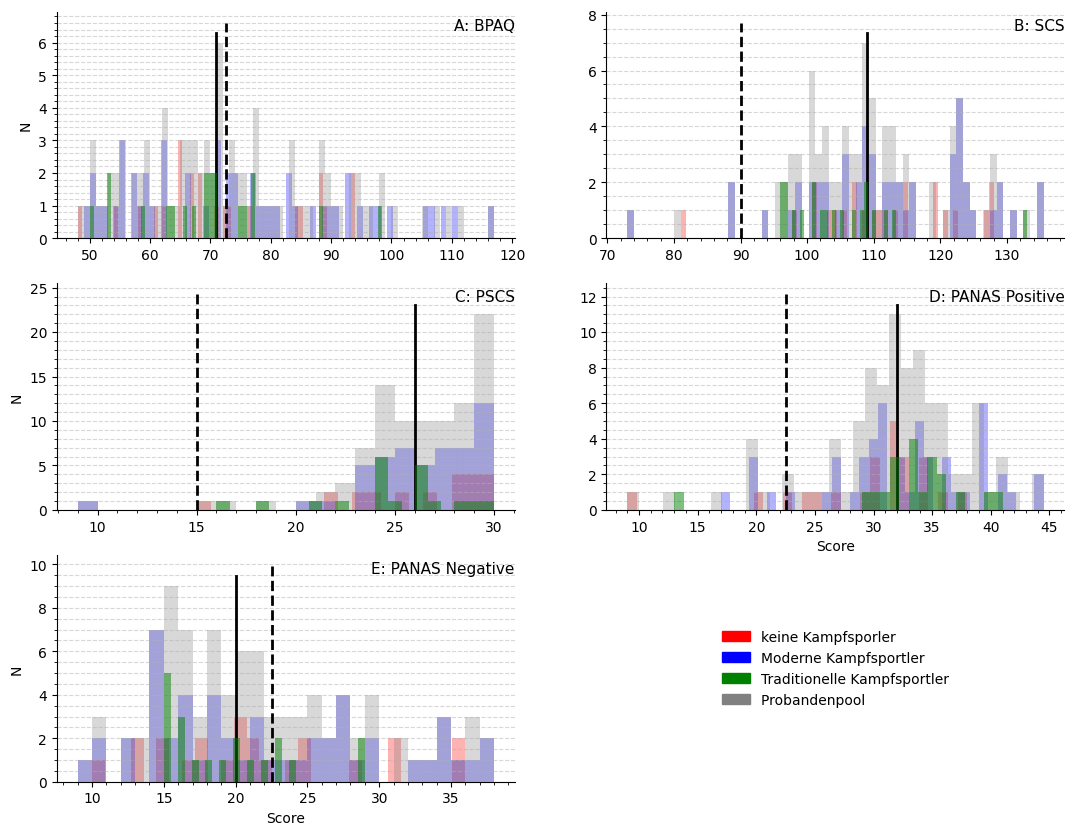

In [22]:
fig = plt.figure(figsize=(13,10),dpi=100)
axes = [fig.add_subplot(3,2,i) for i in range(1,6)]
colors = ["red","blue","green","grey"]
labels = ["keine Kampfsporler","Moderne Kampfsportler","Traditionelle Kampfsportler","Probandenpool "]

for colname,ax in zip([col for col in list(Results) if not re.search("Proband",col) ],[*axes,*axes,*axes]):
    bins = int(ResultsAll[" ".join(colname.split(" ")[:-1])].max() - ResultsAll[" ".join(colname.split(" ")[:-1])].min())
    c = "red" if re.search("NKS",colname) else "green" if re.search("trad", colname) else "blue"
    if c!="green": ax.hist(Results[colname],color=c,alpha=0.3,bins=bins)
    else: ax.hist(Results[colname],color=c,alpha=0.5,bins=bins,zorder=10)
for colname,ax in zip([col for col in list(ResultsAll) if not re.search("Proband",col)],axes):
    bins = int(ResultsAll[colname].max()-ResultsAll[colname].min())
    ax.hist(ResultsAll[colname],color="grey",alpha=0.3,bins=bins)

for colname,(i,ax),label in zip([col for col in list(ResultsAll) if not re.search("Proband",col)],enumerate(axes),["A","B","C","D","E"]):
    ax.spines.top.set_visible(False); ax.spines.right.set_visible(False)
    ax.minorticks_on()
    ax.grid(axis="y",which="both",ls="--",alpha=0.5)
    if i%2==0: ax.set_ylabel("N")
    if i>2: ax.set_xlabel("Score")
    ax.text(ax.get_xlim()[1],ax.get_ylim()[1],label+": "+colname,horizontalalignment="right",verticalalignment="bottom",fontsize=11)
    ax.plot([ResultsAll[colname].median(),ResultsAll[colname].median()],[*ax.get_ylim()],color="black",lw=2)
    with open("fragebogenDic.json", "r", encoding="utf-8") as file:
        dic = json.load(file)
        ax.plot([(dic[colname]*5)/2,(dic[colname]*5)/2],[*ax.get_ylim()],lw=2,ls="--",color="black") # Nochmal abchecken wo der Strich sein sollte, siehe Unten

legendAx = fig.add_subplot(3,2,6)
legendAx.spines.top.set_visible(False); legendAx.spines.bottom.set_visible(False)
legendAx.spines.right.set_visible(False); legendAx.spines.left.set_visible(False)
legendAx.set_xticks([]); legendAx.set_yticks([])
legendAx.legend(
    handles=[mpatches.Patch(color=col, label=label, hatch="o") for col,label in zip(colors,labels)],
    loc="center",frameon=False
)
legendAx.set_zorder(-1)

#plt.tight_layout()
#plt.savefig("./ResultsImg/Histo.svg")

plt.show()

In [40]:
res = {}
for col in ResultsAllNorm:
    res[col] = [[cn,p] for cn,p in ResultsAllNorm[col].items() if p==1]
print(res)

{'BPAQ': [], 'SCS': [], 'PSCS': [[20.0, 1.0], [49.0, 1.0], [50.0, 1.0], [51.0, 1.0], [60.0, 1.0], [62.0, 1.0], [68.0, 1.0], [71.0, 1.0], [72.0, 1.0], [82.0, 1.0]], 'PANAS Positive': [], 'PANAS Negative': []}


In [46]:
[p for p in ResultsNorm["PSCS"+" trad"] if p==1]

[1.0]

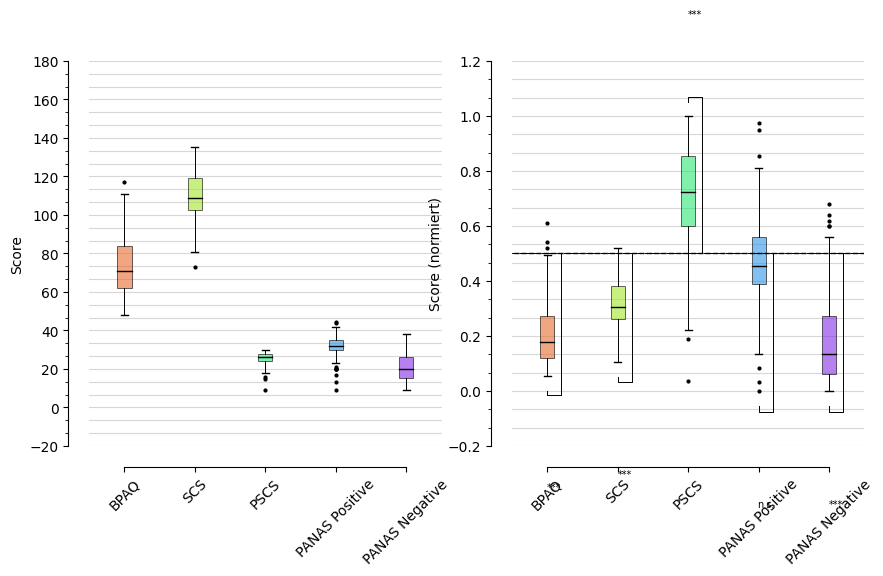

In [106]:
fig = plt.figure(figsize=(10,5),dpi=100)
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
groups = ["BPAQ","SCS","PSCS","PANAS Positive","PANAS Negative"]
niceboxplot(ResultsAll,ax,columns=groups,grid="y",grid_minor=3,ylabel="Score")
stats_norm = niceboxplot(
    ResultsAllNorm,ax2,columns=groups,grid="y",grid_minor=3,ylabel="Score (normiert)",
    compare=[[group,"0.5"] for group in groups], sig_distance=10
)
for a in [ax,ax2]:
    a.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax2.plot([0,6],[0.5,0.5],ls="--",color="black",lw=1) # Wo muss dieser strich sein? 2/10 der Punkte muss man haben! MW also bei 2+4/10? # Macht ein onesample test sinn?
ax2.set_xlim(0.5,5.5)

#stats_norm.to_excel("./ResultsStatistics/NormalNormiert_Pool_norm.xlsx")
#plt.tight_layout()
#plt.savefig("./ResultsImg/NormalNormiert_Pool.svg")

plt.show()

In [109]:
stats_norm[1]

,Shapiro Statistic,Shapiro P,Wilcoxon Statistic,Wilcoxon P,T Statistic,T P
BPAQ-0.5,0.9066663980484009,4.874969818047248e-06,14.0,0.0,NaN,NaN
SCS-0.5,0.9753392338752747,0.06965402513742447,NaN,NaN,-21.041263,0.0
PSCS-0.5,0.9396570920944214,0.00027224887162446976,287.0,0.0,NaN,NaN
PANAS Positive-0.5,0.9822085499763489,0.22478744387626648,NaN,NaN,-1.412547,0.161091
PANAS Negative-0.5,0.8526687026023865,2.7786256850959035e-08,76.0,0.0,NaN,NaN


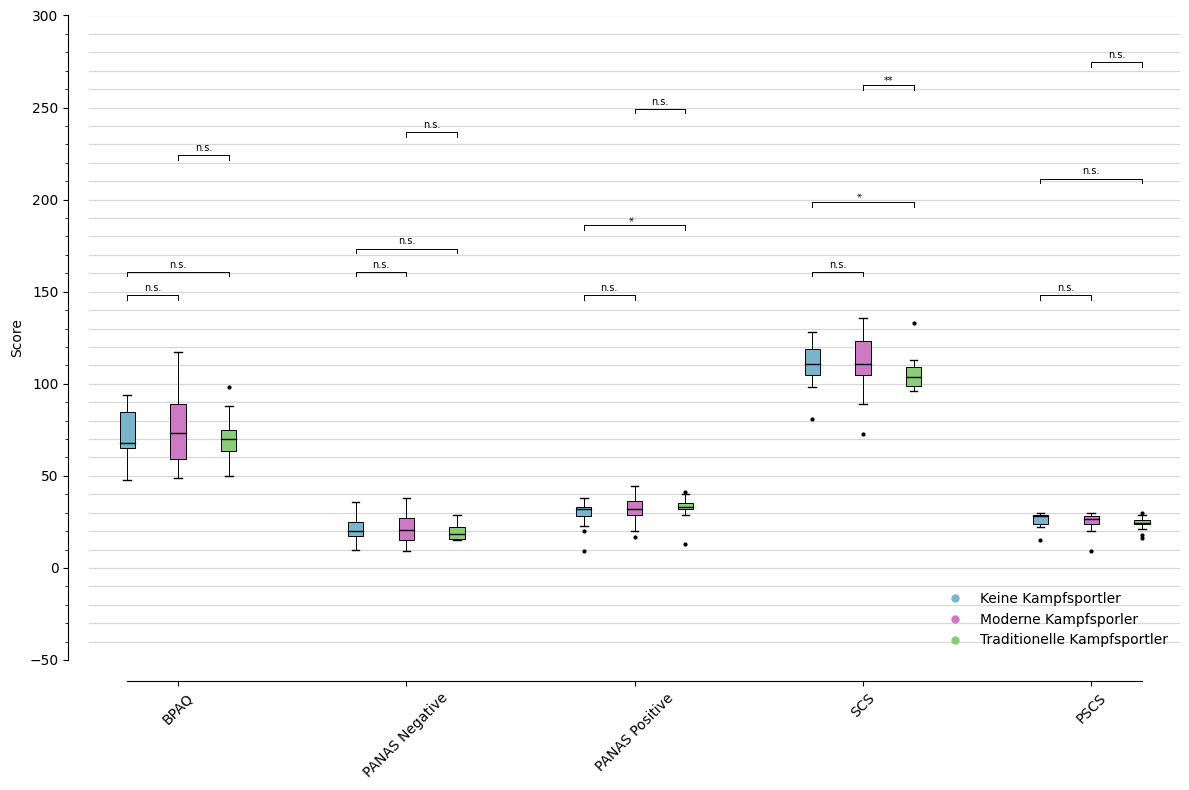

In [21]:
fig = plt.figure(figsize=(12,8),dpi=100)
ax = fig.add_subplot(111)
colors = [(0.55,0.4,0.8),(0.85,0.4,0.8),(0.3,0.4,0.8)]
groups = ["BPAQ","PANAS Negative","PANAS Positive","SCS","PSCS"]
legendLabels = ["Keine Kampfsportler","Moderne Kampfsporler","Traditionelle Kampfsportler"]
stats = niceboxplot(
    Results,ax,groups=[[q+" NKS",q+" KS",q+" trad"] for q in ["BPAQ","PANAS Negative","PANAS Positive","SCS","PSCS"]],
    compare=[[q+" NKS",q+add] for add in [" KS", " trad"] for q in ["BPAQ","PANAS Negative","PANAS Positive","SCS","PSCS"]]+[[q+" KS",q+" trad"] for q in ["BPAQ","PANAS Negative","PANAS Positive","SCS","PSCS"]],
    groupcolors=colors,
    grid="y",grid_minor=5,ylabel="Score",
    legend={legendLabel:col for legendLabel, col in zip(legendLabels,colors)}
)
ax.set_xticks([2,5,8,11,14])
ax.set_xticklabels(groups,rotation=45)
stats[0].to_excel("./ResultsStatistics/GroupBoxDesc.xlsx")
stats[1].to_excel("./ResultsStatistics/GroupBoxTests.xlsx")
plt.tight_layout()
fig.savefig("./ResultsImg/GroupBox.svg")
plt.show()

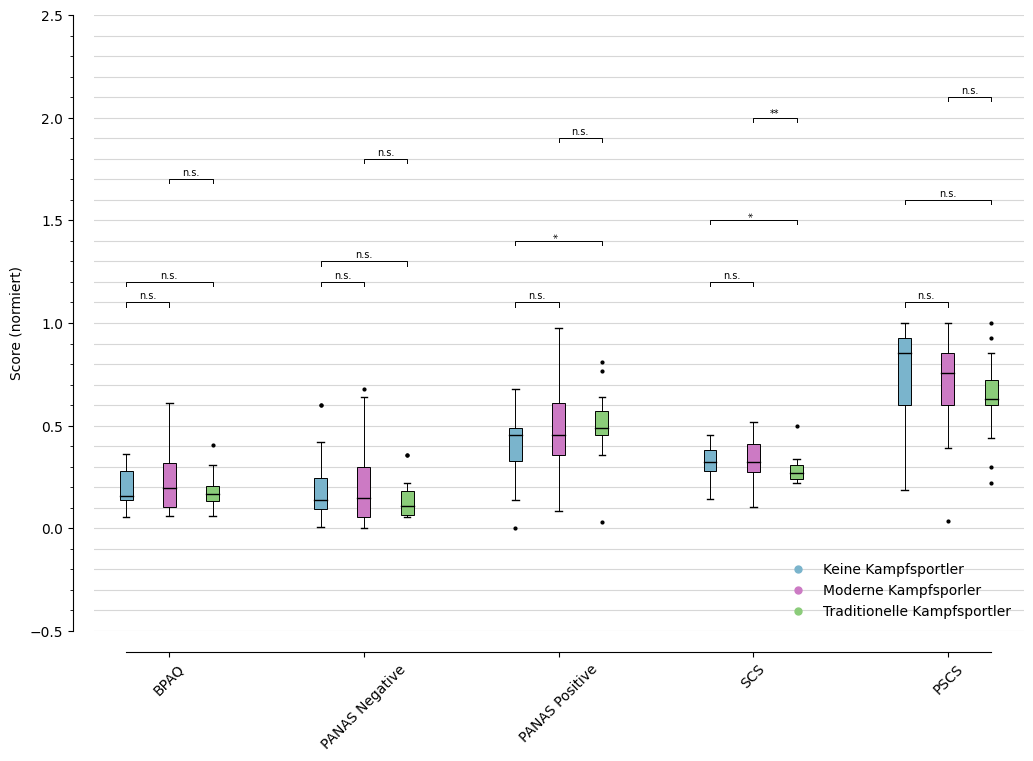

In [98]:
fig = plt.figure(figsize=(12,8),dpi=100)
ax = fig.add_subplot(111)
colors = [(0.55,0.4,0.8),(0.85,0.4,0.8),(0.3,0.4,0.8)]
groups = ["BPAQ","PANAS Negative","PANAS Positive","SCS","PSCS"]
legendLabels = ["Keine Kampfsportler","Moderne Kampfsporler","Traditionelle Kampfsportler"]
stats = niceboxplot(
    ResultsNorm,ax,groups=[[q+" NKS",q+" KS",q+" trad"] for q in groups],
    compare=[[q+" NKS",q+add] for add in [" KS", " trad"] for q in groups]+[[q+" KS",q+" trad"] for q in groups],
    groupcolors=colors,
    grid="y",grid_minor=5,ylabel="Score (normiert)",
    legend={legendLabel:col for legendLabel, col in zip(legendLabels,colors)}
)
ax.set_xticks([2,5,8,11,14])
ax.set_xticklabels(groups,rotation=45)

stats[0].to_excel("./ResultsStatistics/GroupBoxNormDesc.xlsx")
stats[1].to_excel("./ResultsStatistics/GroupBoxNormTests.xlsx")
fig.savefig("./ResultsImg/GroupBoxNorm.svg")
plt.show()

In [12]:
list(regRes._asdict().keys())

['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'intercept_stderr']

In [17]:
list(regRes._asdict().values())

[-0.009067475991196308,
 0.22048112445018372,
 -0.13005903101730856,
 0.4000900705677277,
 0.010666371661298074,
 0.03520233202076887]

In [70]:
labeldic.keys()

dict_keys(['BPAQ', 'SCS', 'PSCS'])

PSCS  LinregressResult(slope=-0.006450334112312218, intercept=0.8588077788004594, rvalue=-0.1469979144112695, pvalue=0.1551638599234592, stderr=0.0045007607133896, intercept_stderr=0.09587337611849989)
PSCS NKS  NKS LinregressResult(slope=-0.015126011773362768, intercept=1.0786837748344371, rvalue=-0.3302158084222712, pvalue=0.12383312601933766, stderr=0.009435076486738254, intercept_stderr=0.2036277955327861)
PANAS Positive NKS  NKS LinregressResult(slope=-0.012178514054893744, intercept=0.6577203030845415, rvalue=-0.3649222972637051, pvalue=0.08687302025918549, stderr=0.006780342791610275, intercept_stderr=0.14633334001614642)
PANAS Positive trad  trad LinregressResult(slope=-0.019005171571327306, intercept=0.9186224583463967, rvalue=-0.40494923089980495, pvalue=0.07653494020997695, stderr=0.010114450410389445, intercept_stderr=0.22151570073595817)


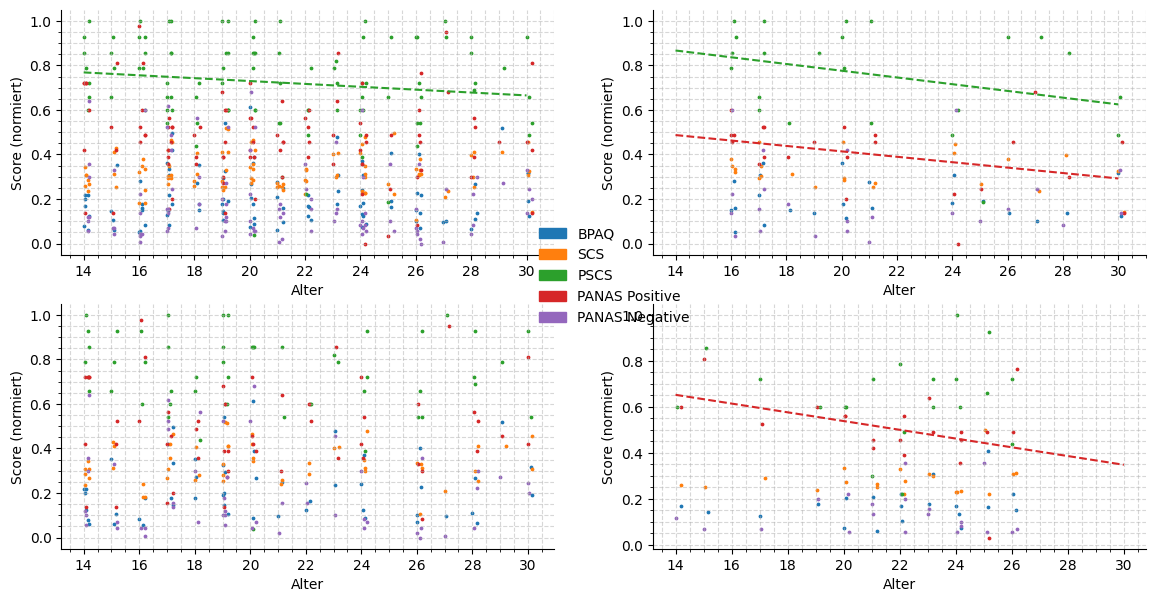

In [73]:
t = ["BPAQ","SCS","PSCS","PANAS Positive","PANAS Negative"]
nks,ks,trad = [[te+s for te in t] for s in [" NKS", " KS"," trad"]]

fig = plt.figure(figsize=(14,7),dpi=100)
axes = [fig.add_subplot(2,2,i) for i in range(1,5)] + [fig.add_axes((0.17,0.45,0.7,0.1),frameon=False,xticks=[],yticks=[])]
labeldic = {}
for sstring, res, ax in zip([""," NKS"," KS"," trad"],[ResultsAllNorm,ResultsNorm[nks],ResultsNorm[ks],ResultsNorm[trad]],axes):
    res = res.dropna() # Aus irgendend einem Grund 1 Datenpunkt mehr bei PANAS
    x = cleanSQ["Alter"]
    for colname,col in res.items():
        y = pd.Series([np.nan if id not in col.index else col[id] for id in x.index], index=x.index)
        p = ax.scatter([_x+np.random.randint(0,5)/20 for _x in x], y,s=3)
        if len(colname.split(" "))<2 or (re.search("PANAS",colname) and len(colname.split(" "))<3): labeldic[colname] = p.get_facecolor()[0]
        mask = ~np.isnan(x) & ~np.isnan(y)
        regRes = linregress(x[mask],y[mask])
        if regRes.pvalue<0.2:
            print(colname,sstring,regRes)
            ls = "-" if regRes.pvalue<0.05 else "--"
            ax.plot(
                        [i for i in range(int(cleanSQ["Alter"].min()),int(cleanSQ["Alter"].max()+1))],
                        [regRes.slope * i + regRes.intercept for i in range(int(cleanSQ["Alter"].min()),int(cleanSQ["Alter"].max()+1))],
                        ls=ls,color=labeldic[(colname.split(" ")[0] if not re.search("PANAS",colname) else " ".join(colname.split(" ")[:-1]))]
            )


for ax in axes[:-1]:
    ax.spines.top.set_visible(False); ax.spines.right.set_visible(False)
    ax.set_ylabel("Score (normiert)"); ax.set_xlabel("Alter")
    ax.minorticks_on()
    ax.grid(axis="both",ls="--",which="both",alpha=0.5)

axes[-1].legend(handles=[mpatches.Patch(color=c, label=l) for l,c in labeldic.items()],loc="center",frameon=False)

plt.savefig("./ResultsImg/KorrelationAlter.svg")
plt.show()


In [23]:
labeldic.items()

dict_items([])

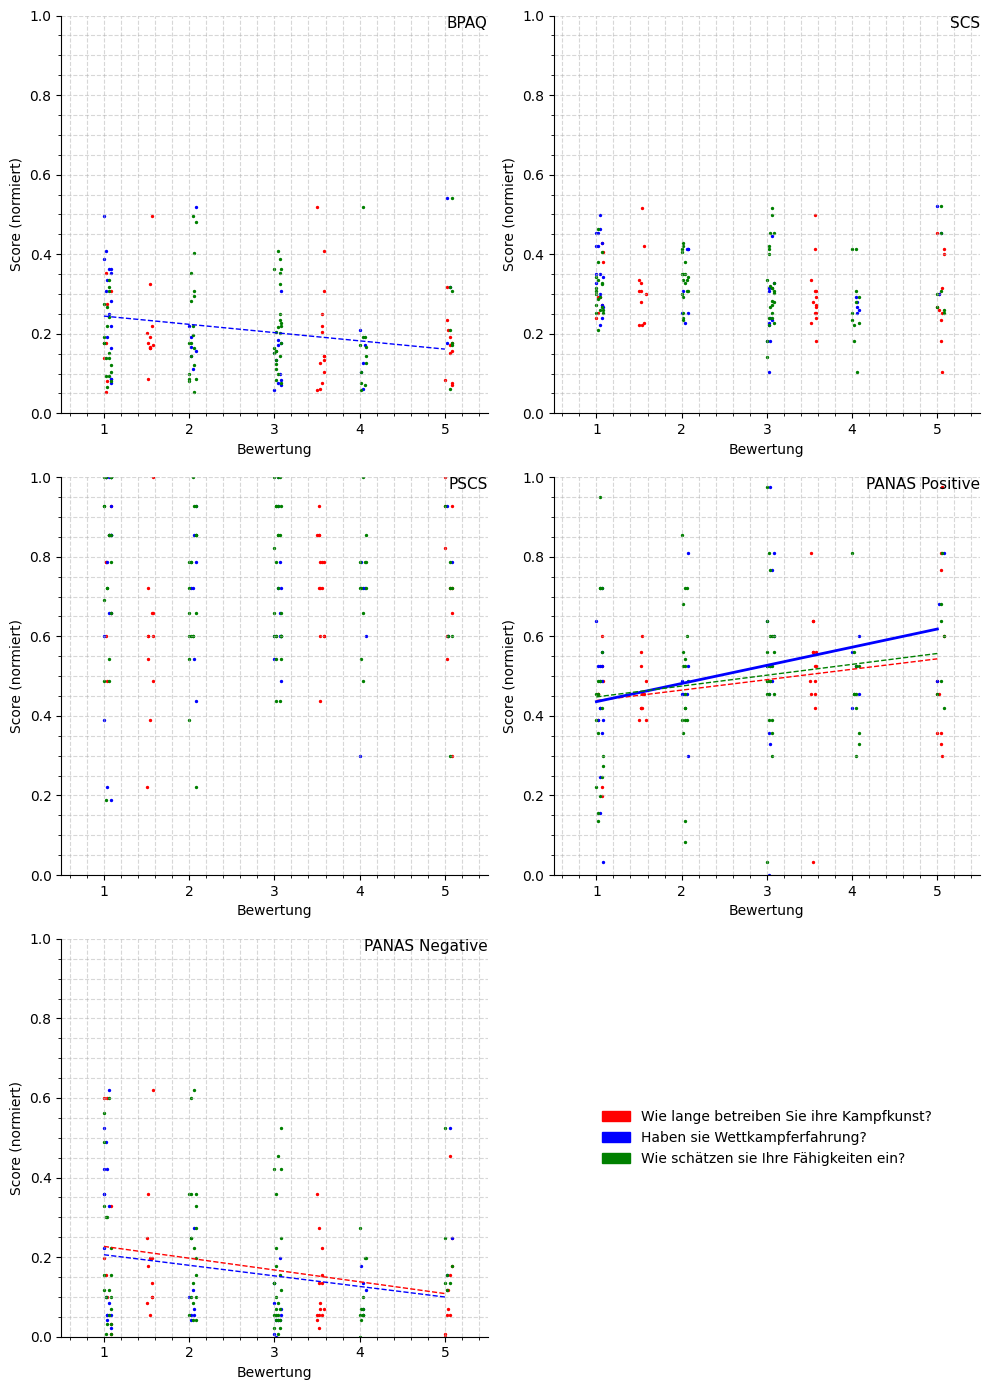

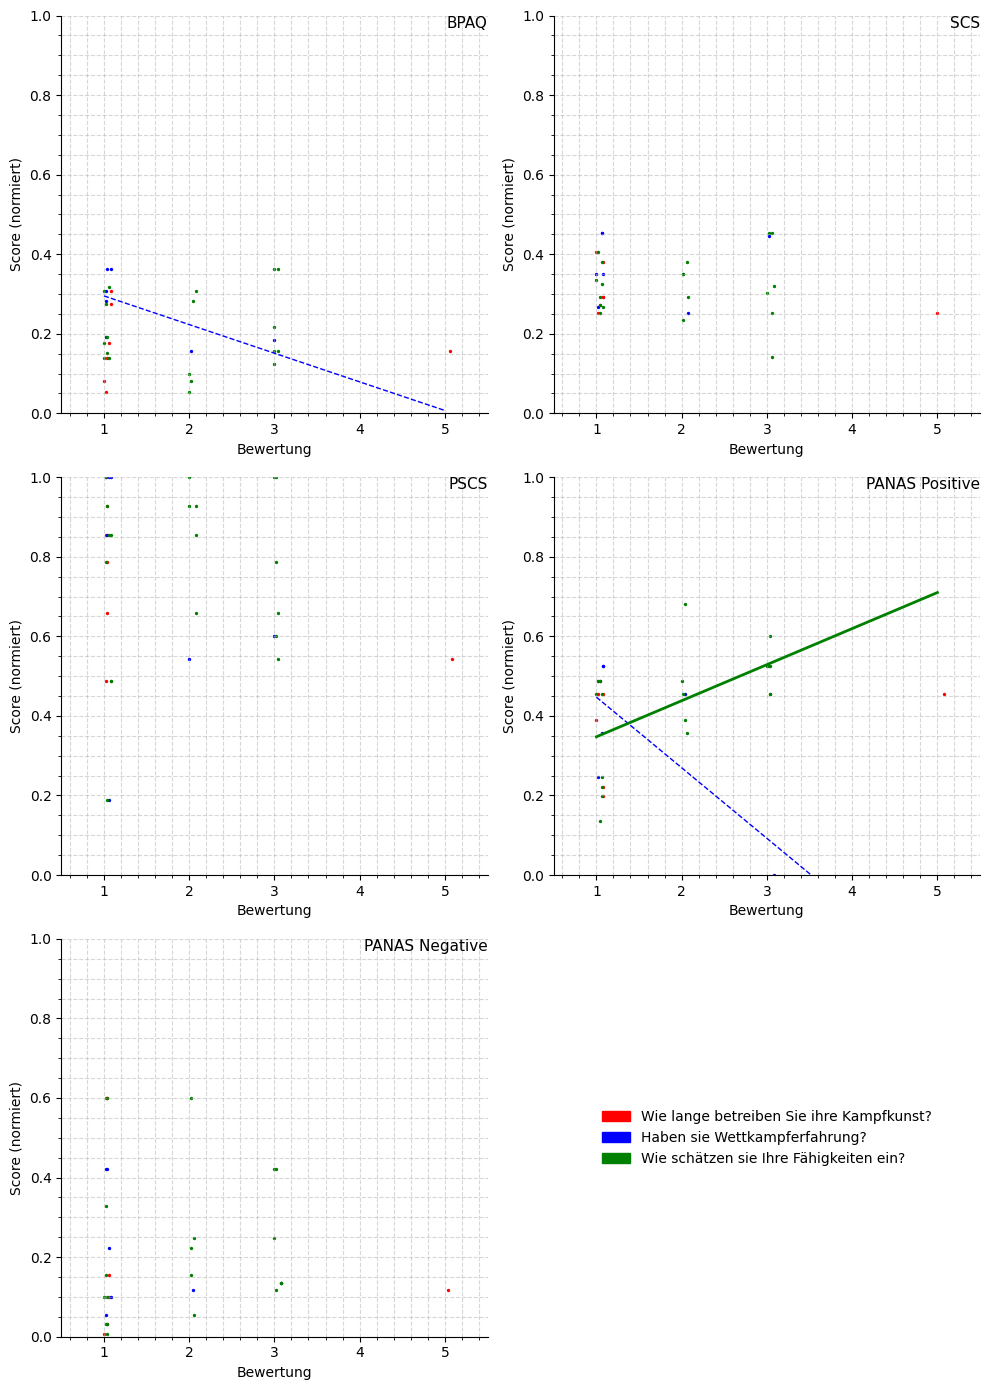

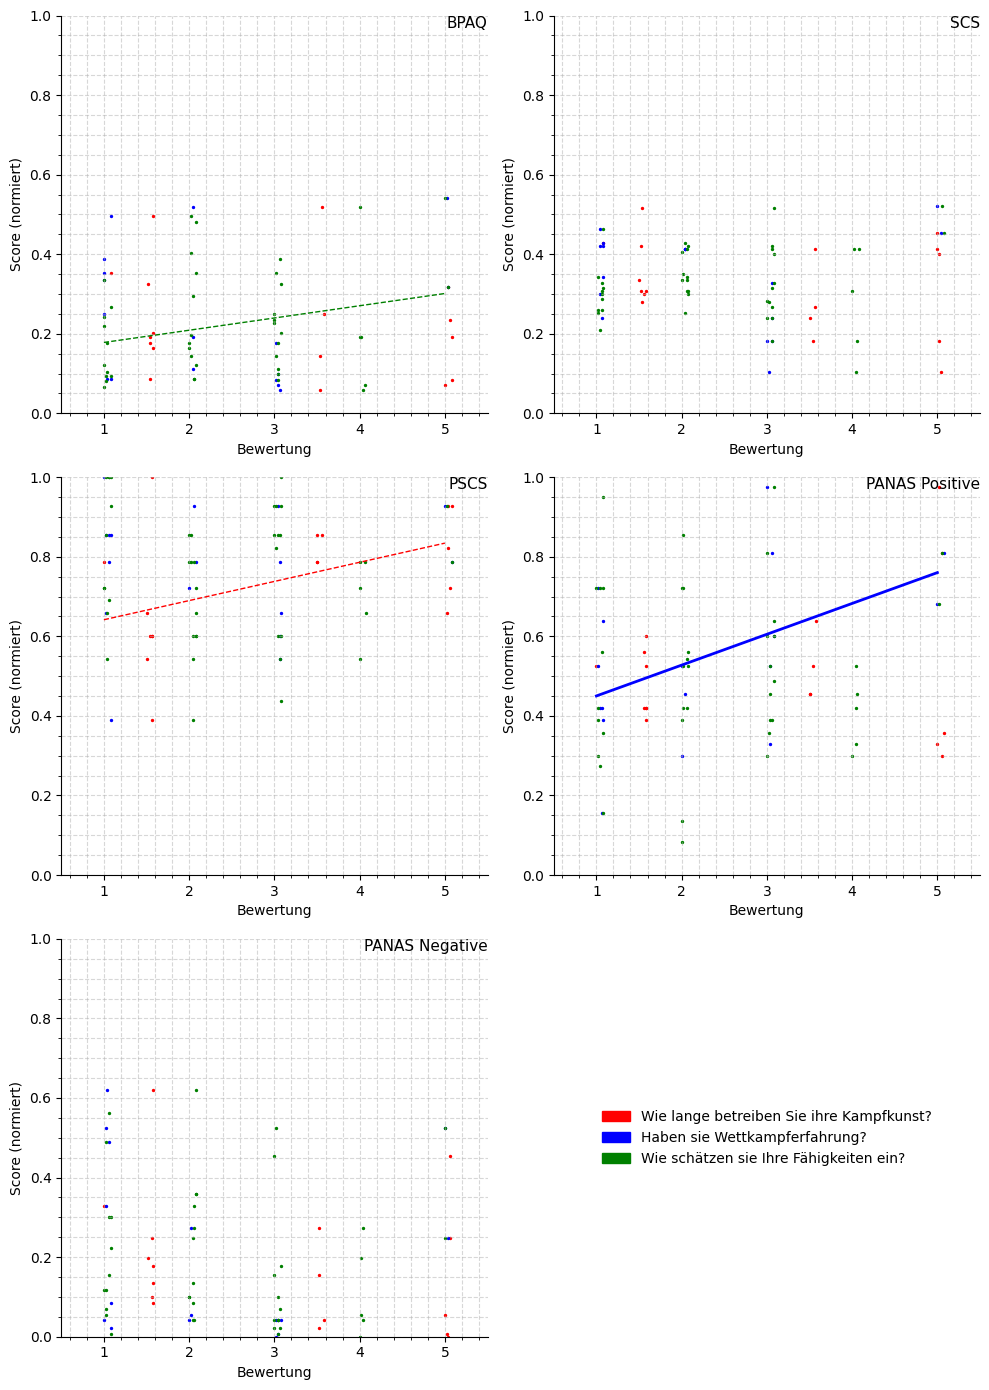

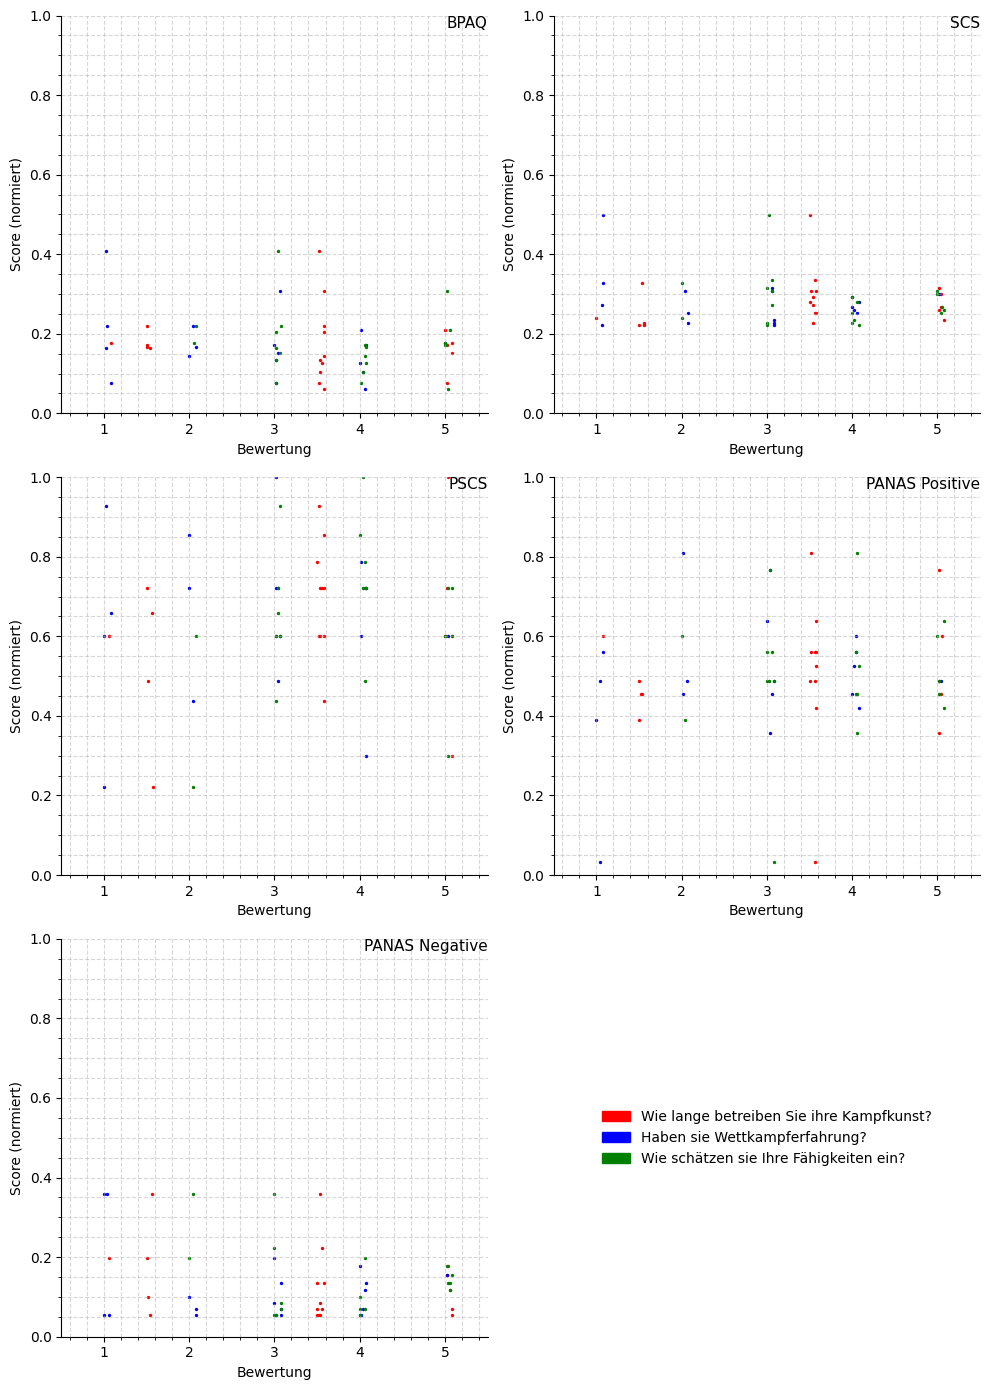

In [4]:
t = ["BPAQ","SCS","PSCS","PANAS Positive","PANAS Negative"]
q = ["Wie lange betreiben Sie ihre Kampfkunst?","Haben sie Wettkampferfahrung?","Wie schätzen sie Ihre Fähigkeiten ein?"]
nks,ks,trad = [[te+s for te in t] for s in [" NKS", " KS"," trad"]]
statisticResults = pd.DataFrame()
for sstring, res in zip([""," NKS"," KS"," trad"],[ResultsAllNorm,ResultsNorm[nks],ResultsNorm[ks],ResultsNorm[trad]]):
    res = res.dropna() # Aus irgendend einem Grund 1 Datenpunkt mehr bei PANAS


    fig = plt.figure(figsize=(10,14),dpi=100)
    axes = [fig.add_subplot(3,2,i) for i in range(1,7)]

    color = {question:col for question,col in zip(q,["red","blue","green","yellow"])}
    for i,question in enumerate(q):
        drop_ind = cleanSQ[question][np.isnan(cleanSQ[question])].index
        x = cleanSQ[question].drop(drop_ind)
        for (colname,col),ax in zip(res.items(),axes):
            ax.set_xlim(0.5,5.5); ax.set_ylim(0,1)
            y = pd.Series([np.nan if id not in col.index else col[id] for id in x.index], index=x.index)
            ax.scatter(
                [_x+np.random.randint(0,5)/50 for _x in x],
                y,s=2,c=color[question]
            )
            mask = ~np.isnan(x) & ~np.isnan(y)
            regRes = linregress(x[mask],y[mask])
            if regRes.pvalue<0.2:
                statisticResults = pd.concat([statisticResults, pd.DataFrame(
                    {f"{sstring}: {question}-{colname}":list(regRes._asdict().values())+["ja" if regRes.pvalue<0.05 else "nein"]},
                    index=list(regRes._asdict().keys())+["korreliert"]
                )],axis=1)
                fitParams = calcFitParams(regRes,[x,y])
                ls = "-" if regRes.pvalue<0.05 else "--"
                lw = 2 if regRes.pvalue<0.05 else 1
                fs = 11 if regRes.pvalue<0.05 else 9
                ax.plot(
                    [i for i in range(int(cleanSQ[question].min()),int(cleanSQ[question].max()+1))],
                    [regRes.slope * i + regRes.intercept for i in range(int(cleanSQ[question].min()),int(cleanSQ[question].max()+1))],
                    color=color[question], ls=ls, lw=lw
                )
            #textposoffset = np.random.randint(-((y.max()-y.min())/3),((y.max()-y.min())/3))
            """textposoffset = 0
            ax.text(
                np.mean([i for i in range(int(cleanSQ[question].min()),int(cleanSQ[question].max()+1))])+np.random.randint(-2,2),
                np.mean([regRes.slope * i + regRes.intercept for i in range(int(cleanSQ[question].min()),int(cleanSQ[question].max()+1))])+textposoffset,
                f" r={round(regRes.rvalue,2)}\n p={round(regRes.pvalue,4)}",
                color = color[question], fontsize= fs, zorder=10
            )"""

    for ax,colname in zip(axes,list(res)):
        ax.spines.top.set_visible(False); ax.spines.right.set_visible(False)
        ax.minorticks_on()
        ax.grid(True,"both","both",ls="--",alpha=0.5)
        ax.text(ax.get_xlim()[1],ax.get_ylim()[1],colname.replace(sstring,"").replace(sstring,"").replace(sstring,""),verticalalignment="top",horizontalalignment="right",fontsize=11)
        ax.set_xlabel("Bewertung"); ax.set_ylabel("Score (normiert)")
    
    axes[-1].legend(handles=[mpatches.Patch(color=c, label=l) for c,l in zip(color.values(),q)],loc="center",frameon=False)
    axes[-1].spines.top.set_visible(False); axes[-1].spines.left.set_visible(False); axes[-1].spines.right.set_visible(False); axes[-1].spines.bottom.set_visible(False)
    axes[-1].set_yticks([]); axes[-1].set_xticks([])

    plt.tight_layout()
    plt.savefig(f"./ResultsImg/SelbstKorrelation_{sstring}.svg")
    plt.show()

statisticResults.to_excel("./ResultsStatistics/SelfKorrelation.xlsx")


In [6]:
statisticResults

,: BPAQ-SCS,: BPAQ-PANAS Positive,: BPAQ-PANAS Negative,: SCS-BPAQ,: SCS-PSCS,: SCS-PANAS Positive,: SCS-PANAS Negative,: PSCS-SCS,: PSCS-PANAS Positive,: PANAS Positive-BPAQ,...,trad: SCS trad-PANAS Positive trad,trad: SCS trad-PANAS Negative trad,trad: PSCS trad-PANAS Negative trad,trad: PANAS Positive trad-BPAQ trad,trad: PANAS Positive trad-SCS trad,trad: PANAS Positive trad-PANAS Negative trad,trad: PANAS Negative trad-BPAQ trad,trad: PANAS Negative trad-SCS trad,trad: PANAS Negative trad-PSCS trad,trad: PANAS Negative trad-PANAS Positive trad
slope,0.445039,-0.260361,0.828641,0.950732,0.389167,-0.546121,1.004423,0.0691,0.171541,-0.103716,...,-1.23265,0.922148,-0.159009,-0.203744,-0.188647,-0.329127,0.563068,0.409129,-0.648492,-0.954139
intercept,0.228706,0.526483,0.019547,-0.097248,0.599349,0.647776,-0.13066,0.271368,0.347968,0.257321,...,0.855004,-0.123926,0.238769,0.276943,0.377866,0.303216,0.096868,0.226429,0.732831,0.637206
rvalue,0.650471,-0.164328,0.588008,0.650471,0.163986,-0.235827,0.487644,0.163986,0.175793,-0.164328,...,-0.48222,0.614229,-0.321117,-0.406909,-0.48222,-0.560386,0.660465,0.614229,-0.321117,-0.560386
pvalue,0.0,0.111541,0.0,0.0,0.112298,0.02141,0.000001,0.112298,0.088375,0.111541,...,0.0313,0.003961,0.167433,0.074985,0.0313,0.010171,0.001526,0.003961,0.167433,0.010171
stderr,0.053886,0.162061,0.118199,0.115116,0.242755,0.233361,0.18647,0.043103,0.099611,0.064558,...,0.527822,0.279242,0.110533,0.107806,0.080779,0.114655,0.15088,0.123891,0.450788,0.332384
intercept_stderr,0.012963,0.038986,0.028434,0.038194,0.080544,0.077427,0.061869,0.03234,0.074738,0.032875,...,0.152353,0.080602,0.074079,0.057176,0.042842,0.060808,0.024737,0.020312,0.073906,0.054494
korreliert,ja,nein,ja,ja,nein,ja,ja,nein,nein,nein,...,ja,ja,nein,nein,ja,ja,ja,ja,nein,ja


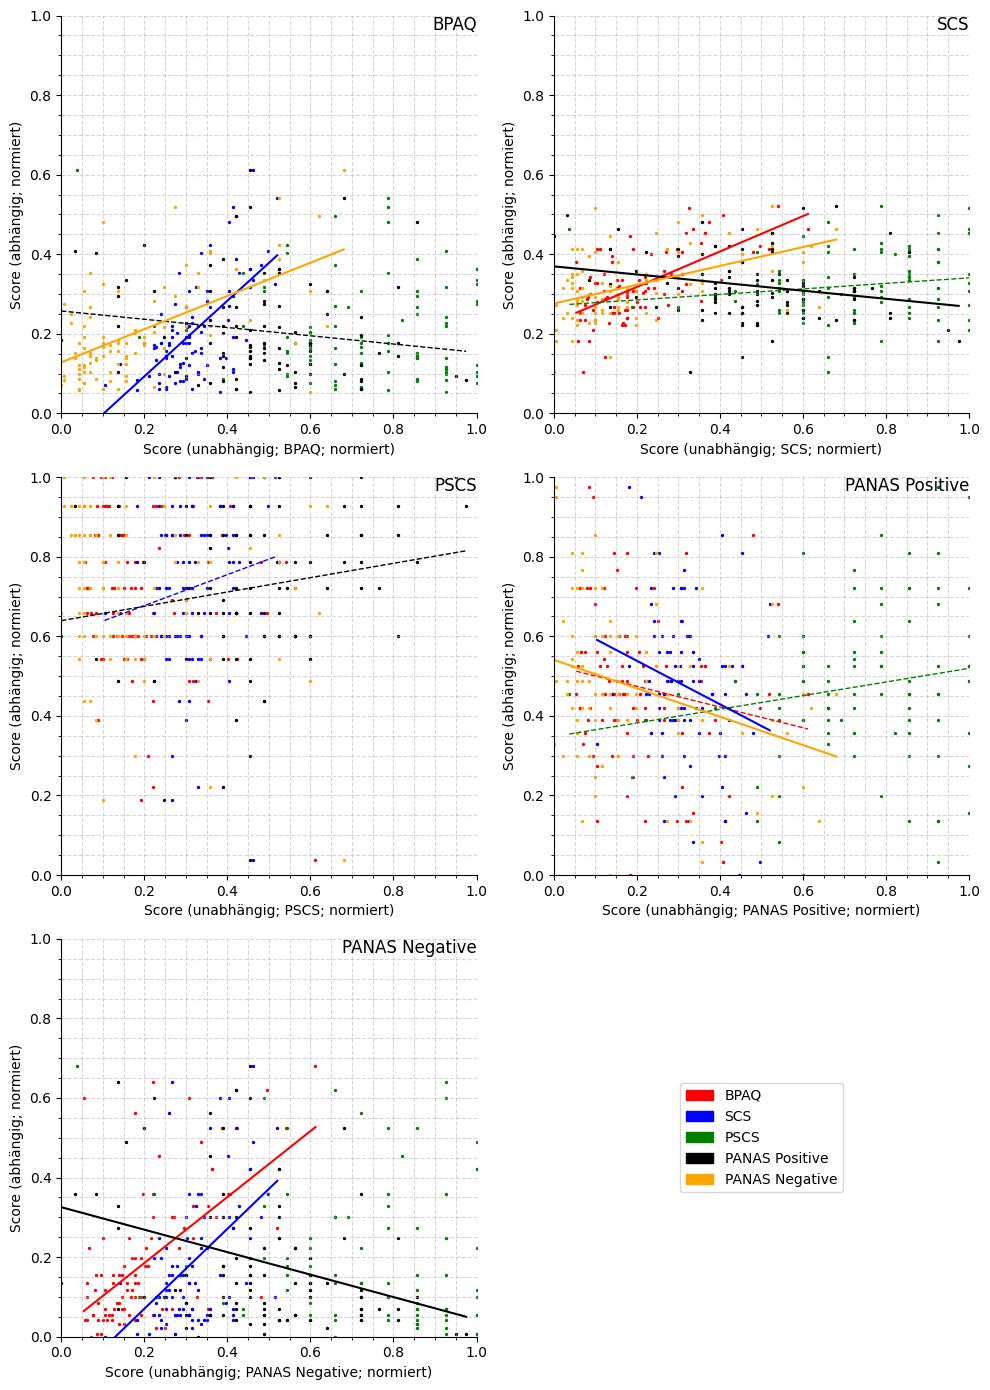

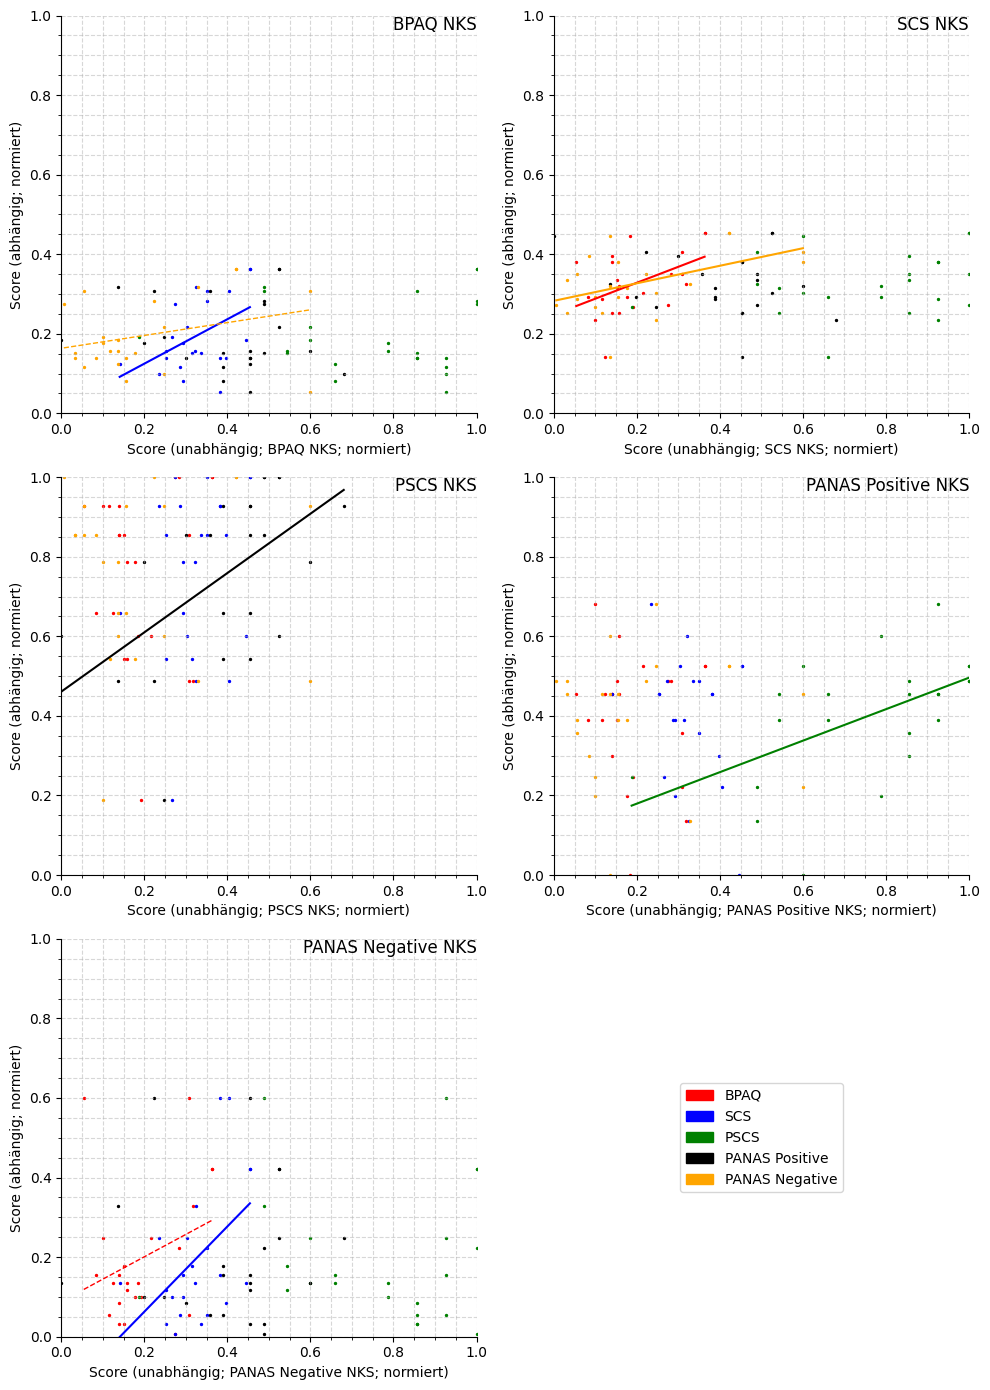

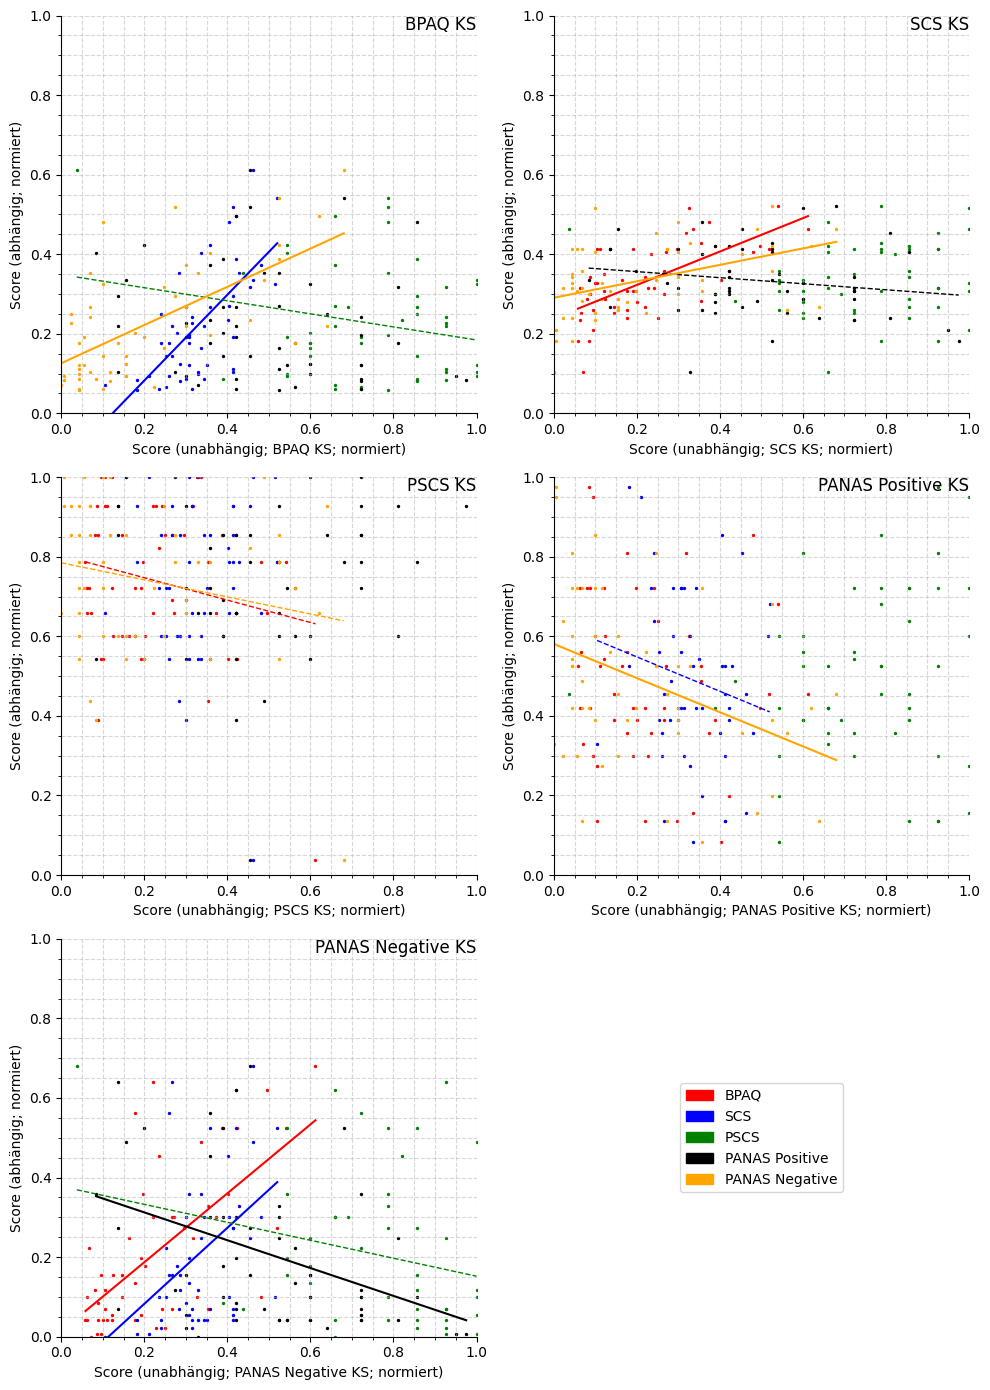

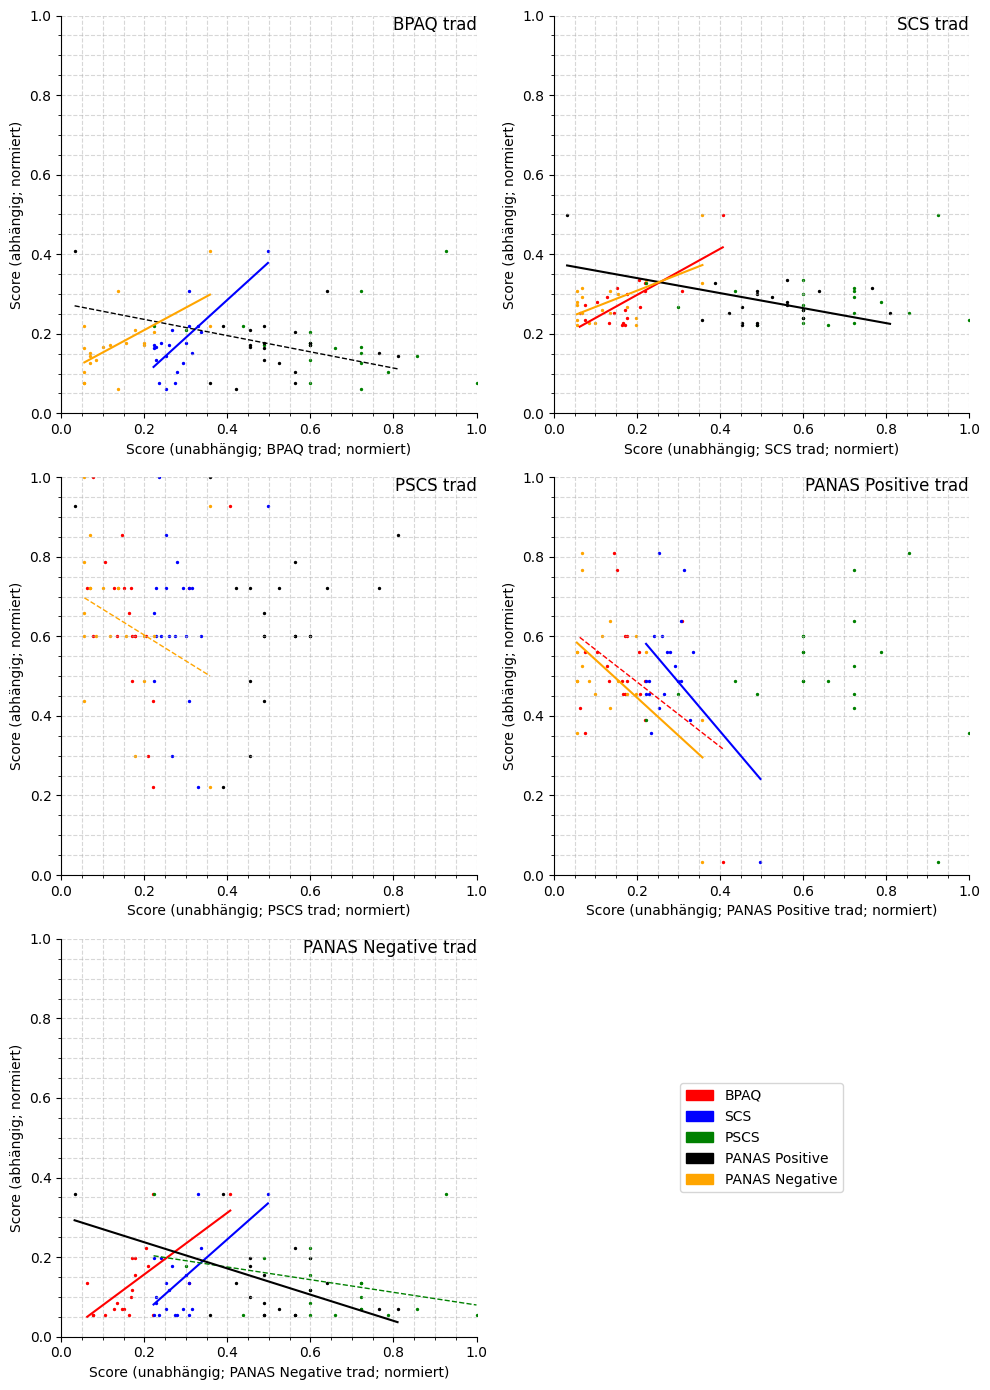

In [5]:
t = ["BPAQ","SCS","PSCS","PANAS Positive","PANAS Negative"]
nks,ks,trad = [[te+s for te in t] for s in [" NKS", " KS"," trad"]]
statisticResults = pd.DataFrame()
for sstring, res in zip([""," NKS"," KS"," trad"],[ResultsAllNorm,ResultsNorm[nks],ResultsNorm[ks],ResultsNorm[trad]]):
    res = res.dropna() # Aus irgendend einem Grund 1 Datenpunkt mehr bei PANAS

    fig = plt.figure(figsize=(10,14),dpi=100)
    axes = [fig.add_subplot(3,2,i) for i in range(1,7)]

    color = {te:col for te,col in zip(t,["red","blue","green","black","orange"])}
    for onlyfortextpos,test in enumerate(t):
        question = test + sstring
        for (colname,col),ax in zip(res.items(),axes):
            ax.set_ylim(0,1); ax.set_xlim(0,1)
            if question==colname: continue
            data = [res[question][~np.isnan(res[question])],col[~np.isnan(col)]]
            ax.scatter(res[question],col,s=2,c=color[test])
            regRes = linregress(data[0],data[1])
            if regRes.pvalue < 0.05:
                #print(colname," | ",question," -> ",f"\tr={round(regRes.rvalue,2)}, p={round(regRes.pvalue,4)}")
                fitParams = calcFitParams(regRes,data)
                #plot_ci_bootstrap(*data, fitParams["resid"], ax=ax, color=color[test])
                ls = "-"; lw=1.5; fs = 11
            else: ls = "--"; lw = 1; fs = 9
            if regRes.pvalue<0.2:
                statisticResults = pd.concat([statisticResults, pd.DataFrame(
                    {f"{sstring}: {question}-{colname}":list(regRes._asdict().values())+["ja" if regRes.pvalue<0.05 else "nein"]},
                    index=list(regRes._asdict().keys())+["korreliert"]
                )],axis=1)
                ax.plot(
                    [i for i in np.linspace(res[question].min(),res[question].max())],
                    [regRes.slope * i + regRes.intercept for i in np.linspace(res[question].min(),res[question].max())],
                    color = color[test],ls=ls,lw=lw
                )
            """textpos = [0.05,1-onlyfortextpos/20]
            ax.text(
                *textpos,
                f" r={round(regRes.rvalue,2)}\n p={round(regRes.pvalue,4)}",
                color = color[test], fontsize=fs
            )"""

    for ax,colname in zip(axes,list(res)):
        ax.spines.top.set_visible(False); ax.spines.right.set_visible(False)
        ax.text(ax.get_xlim()[1],ax.get_ylim()[1],colname,verticalalignment="top",horizontalalignment="right",fontsize=12)
        ax.minorticks_on()
        ax.set_ylabel("Score (abhängig; normiert)"); ax.set_xlabel(f"Score (unabhängig; {colname}; normiert)")
        ax.grid(True,"both","both",ls="--",alpha=0.5)

    axes[-1].legend(handles=[mpatches.Patch(color=col, label=lab) for lab,col in color.items()],loc="center")
    axes[-1].spines.top.set_visible(False); axes[-1].spines.right.set_visible(False); axes[-1].spines.left.set_visible(False); axes[-1].spines.bottom.set_visible(False)
    axes[-1].set_xticks([]); axes[-1].set_yticks([])

    plt.tight_layout()
    plt.savefig(f"./ResultsImg/TestKorrelation_{sstring}.svg")

    plt.show()

statisticResults.to_excel("./ResultsStatistics/TestsKorrelation.xlsx")
